<a href="https://colab.research.google.com/github/siwar-ajmi/projet-r-/blob/main/mammographie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Audit Stratégique du Parc de Mammographie en Tunisie
##Problématique et Impact:
Le cancer du sein représente le premier cancer féminin en Tunisie. Cet audit technologique du parc hospitalier public vise à répondre à une question de santé publique majeure : Le réseau public est-il équipé pour un dépistage précoce équitable ? Ce projet analyse la fracture numérique territoriale en segmentant les équipements par technologie (Numérique vs Conventionnel) et par région, offrant ainsi un outil d'aide à la décision pour les futures politiques de santé.et aussi Cet audit permet d'identifier les zones prioritaires pour l'investissement public afin de garantir une équité de diagnostic entre le Grand Tunis et les régions intérieures.
Commençons par charger les packages nécessaires à notre analyse.

In [1]:
# Installation avec les dépendances minimales pour éviter l'échec
if (!require("plotly")) install.packages("plotly", dependencies = c("Depends", "Imports"))

# Chargement
library(tidyverse)
library(plotly)

# Configuration pour forcer l'affichage dans Google Colab
options(plotly.renderers = "colab")

print("Installation réussie et moteur de rendu Colab activé !")

Loading required package: plotly

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘plotly’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘lazyeval’, ‘crosstalk’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

  

[1] "Installation réussie et moteur de rendu Colab activé !"


 ## 2. Lecture et Structuration des Données
Nous procédons à l'importation de l'inventaire complet des équipements de mammographie par établissement hospitalier en Tunisie à partir du fichier source.
 ### Pourquoi cette approche ?
L'importation des données brutes nécessite une attention particulière pour garantir la validité des analyses futures :
**Gestion du format "Flat"** : Le fichier étant structuré sans séparateurs complexes, nous utilisons la fonction `read.csv` avec un séparateur virgule pour isoler correctement les variables.
**Élimination des résidus d'en-tête** : L'utilisation de l'argument `skip = 1` est ici cruciale. Nous utilisons skip = 1 pour ignorer l'en-tête textuel du CSV qui contient des noms de colonnes. Cela évite d'importer du texte dans des colonnes numériques, ce qui causerait des erreurs de calcul, ce qui fausserait les calculs statistiques et les palettes de couleurs des graphiques.
**Définition manuelle des colonnes** : Nous définissons explicitement les noms des colonnes (marque, intitule, quantite, destination) pour assurer une structure de données cohérente dès l'entrée en mémoire. L'objectif de cette étape est de transformer un fichier brut en un data frame structuré, prêt pour les opérations de nettoyage et d'enrichissement.

In [5]:
# Lecture du fichier CSV en sautant la première ligne (les titres)
# Cela évite d'importer la ligne "marque, intitule..." comme une donnée réelle
mammo_data <- read.csv('/content/sample_data/equipement_mammographie_hopitaux_publics_sans_annee.csv',
                       sep = ",",
                       header = FALSE,
                       skip = 1,
                       col.names = c("marque", "intitule", "quantite", "destination"),
                       stringsAsFactors = FALSE)
# Conversion de la colonne quantité en type numérique pour les analyses statistiques
mammo_data$quantite <- as.numeric(mammo_data$quantite)
# Affichage des dimensions pour confirmer l'importation propre
print(paste("Nombre total d'équipements réels importés :", nrow(mammo_data)))
# Aperçu du contenu structuré
head(mammo_data)

[1] "Nombre total d'équipements réels importés : 31"


,marque,intitule,quantite,destination
,<chr>,<chr>,<dbl>,<chr>
1,GE,Mammographe conventionnel,1,EPS CHARLES NICOLLE
2,GE,Mammographe conventionnel,1,HR GABES
3,GE,Mammographe conventionnel,1,EPS HABIB BOURGUIBA SFAX
4,GE,Mammographe conventionnel,1,EPS FARHAT HACHED SOUSSE
5,GE,Mammographe conventionnel,1,EPS MONGI SLIM LA MARSA
6,GE,Mammographe conventionnel,1,EPS HABIB THAMEUR


# 3. Nettoyage et Enrichissement des Données (Data Cleaning)
Le nettoyage est l'étape déterminante pour transformer des données brutes en indicateurs fiables. Sans cette phase, les erreurs de saisie fausseraient l'audit du parc technologique.
 ### Justification des traitements :
**Normalisation et Standardisation** : Nous appliquons `trimws()` et `toupper()` pour éliminer les espaces parasites et uniformiser les noms des marques (ex: fusionner "GE" et "ge"). Cela garantit l'exactitude des comptages par constructeur.
**Ingénierie des variables (Feature Engineering)** : La création de la variable `region` est l'ajout majeur de cette étape. En segmentant géographiquement les établissements hospitaliers (Grand Tunis, Nord, Sahel, Sud, Centre), nous passons d'une simple liste descriptive à une analyse territoriale permettant d'identifier les zones prioritaires pour de futurs investissements.
**Préparation Statistique** : Nous générons un tableau croisé `tech_summary` qui servira de base à notre visualisation interactive, assurant une transition fluide entre les données et l'analyse visuelle.

In [7]:
library(dplyr)
library(stringr)

# 1. Normalisation des données et Feature Engineering (Création des régions)
df_clean <- mammo_data %>%
  mutate(
    marque = trimws(toupper(marque)),
    intitule = trimws(intitule),
    destination = trimws(destination)
  ) %>%
  mutate(region = case_when(
    str_detect(destination, "TUNIS|AROUS|MARSA|NICOLLE|RABTA|THAMEUR|AZAIEZ|ARIANA") ~ "Grand Tunis",
    str_detect(destination, "SFAX") ~ "Sfax",
    str_detect(destination, "SOUSSE|MONASTIR|MAHDIA") ~ "Sahel",
    str_detect(destination, "GABES|KEBILI|MEDENINE|ZARZIS|GAFSA|TOZEUR") ~ "Sud",
    str_detect(destination, "BIZERTE|BEJA|KEF|JENDOUBA") ~ "Nord",
    TRUE ~ "Centre/Autres"
  ))

# 2. Agrégation des données pour le Dashboard et les Statistiques
tech_summary <- df_clean %>% count(intitule)
region_summary <- df_clean %>% count(region) # Ajout crucial pour l'analyse régionale

# Affichage pour contrôle
print("--- Aperçu des données nettoyées ---")
head(df_clean)
print("--- Résumé par Technologie ---")
print(tech_summary)
print("--- Résumé par Région ---")
print(region_summary)

[1] "--- Aperçu des données nettoyées ---"


,marque,intitule,quantite,destination,region
,<chr>,<chr>,<dbl>,<chr>,<chr>
1,GE,Mammographe conventionnel,1,EPS CHARLES NICOLLE,Grand Tunis
2,GE,Mammographe conventionnel,1,HR GABES,Sud
3,GE,Mammographe conventionnel,1,EPS HABIB BOURGUIBA SFAX,Sfax
4,GE,Mammographe conventionnel,1,EPS FARHAT HACHED SOUSSE,Sahel
5,GE,Mammographe conventionnel,1,EPS MONGI SLIM LA MARSA,Grand Tunis
6,GE,Mammographe conventionnel,1,EPS HABIB THAMEUR,Grand Tunis


[1] "--- Résumé par Technologie ---"
                   intitule  n
1 Mammographe conventionnel 19
2     Mammographe numerique 12
[1] "--- Résumé par Région ---"
         region n
1 Centre/Autres 6
2   Grand Tunis 8
3          Nord 4
4         Sahel 4
5          Sfax 2
6           Sud 7


## 4.Exploration et Analyse des Données

Maintenant que nos données sont nettoyées et enrichies avec les variables régionales, nous allons procéder à l'exploration visuelle. Cette étape est cruciale pour répondre à nos problématiques de santé publique :

1.  **Analyse des Équipements :** Quelle est la proportion de machines modernes (Numériques) par rapport aux anciennes (Conventionnelles) ?
2.  **Analyse de la Fracture Numérique :** Comment le taux de modernisation varie-t-il selon les régions géographiques ?
3.  **Analyse des Constructeurs :** Quelles sont les marques dominantes dans les hôpitaux publics tunisiens ?

Nous utilisons des bibliothèques interactives pour permettre une exploration dynamique des résultats.

Warning message in geom_bar(stat = "identity", color = "white", size = 1.5):
“Ignoring unknown parameters: `size`”


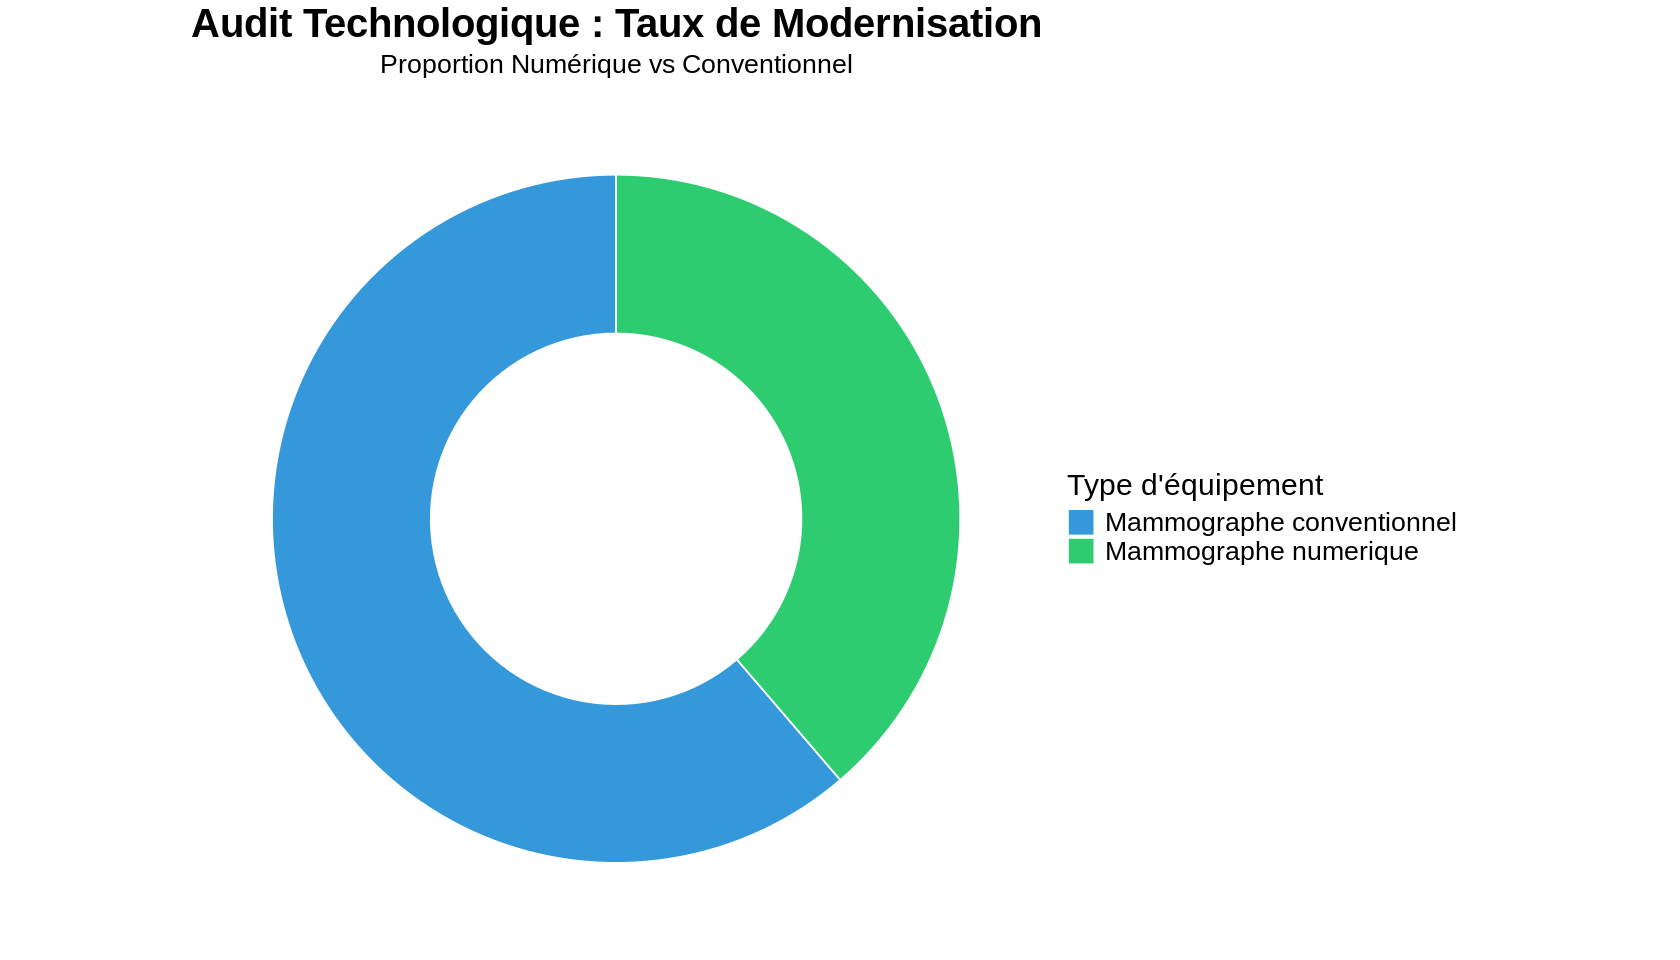

In [24]:
# Création du graphique de modernisation
# 1. Définir une grande taille pour le rendu
options(repr.plot.width = 14, repr.plot.height = 8)

# 2. Création du Donut Chart
p1 <- ggplot(tech_summary, aes(x = 2, y = n, fill = intitule)) +
  geom_bar(stat = "identity", color = "white", size = 1.5) +
  coord_polar(theta = "y") +
  xlim(0.5, 2.5) + # Crée l'effet de "trou" au milieu (Donut)
  theme_void() +
  scale_fill_manual(values = c("#3498db", "#2ecc71")) +
  labs(title = "Audit Technologique : Taux de Modernisation",
       subtitle = "Proportion Numérique vs Conventionnel",
       fill = "Type d'équipement") +
  theme(plot.title = element_text(size = 24, face = "bold", hjust = 0.5),
        plot.subtitle = element_text(size = 16, hjust = 0.5),
        legend.text = element_text(size = 16),
        legend.title = element_text(size = 18))

p1


[1] 1

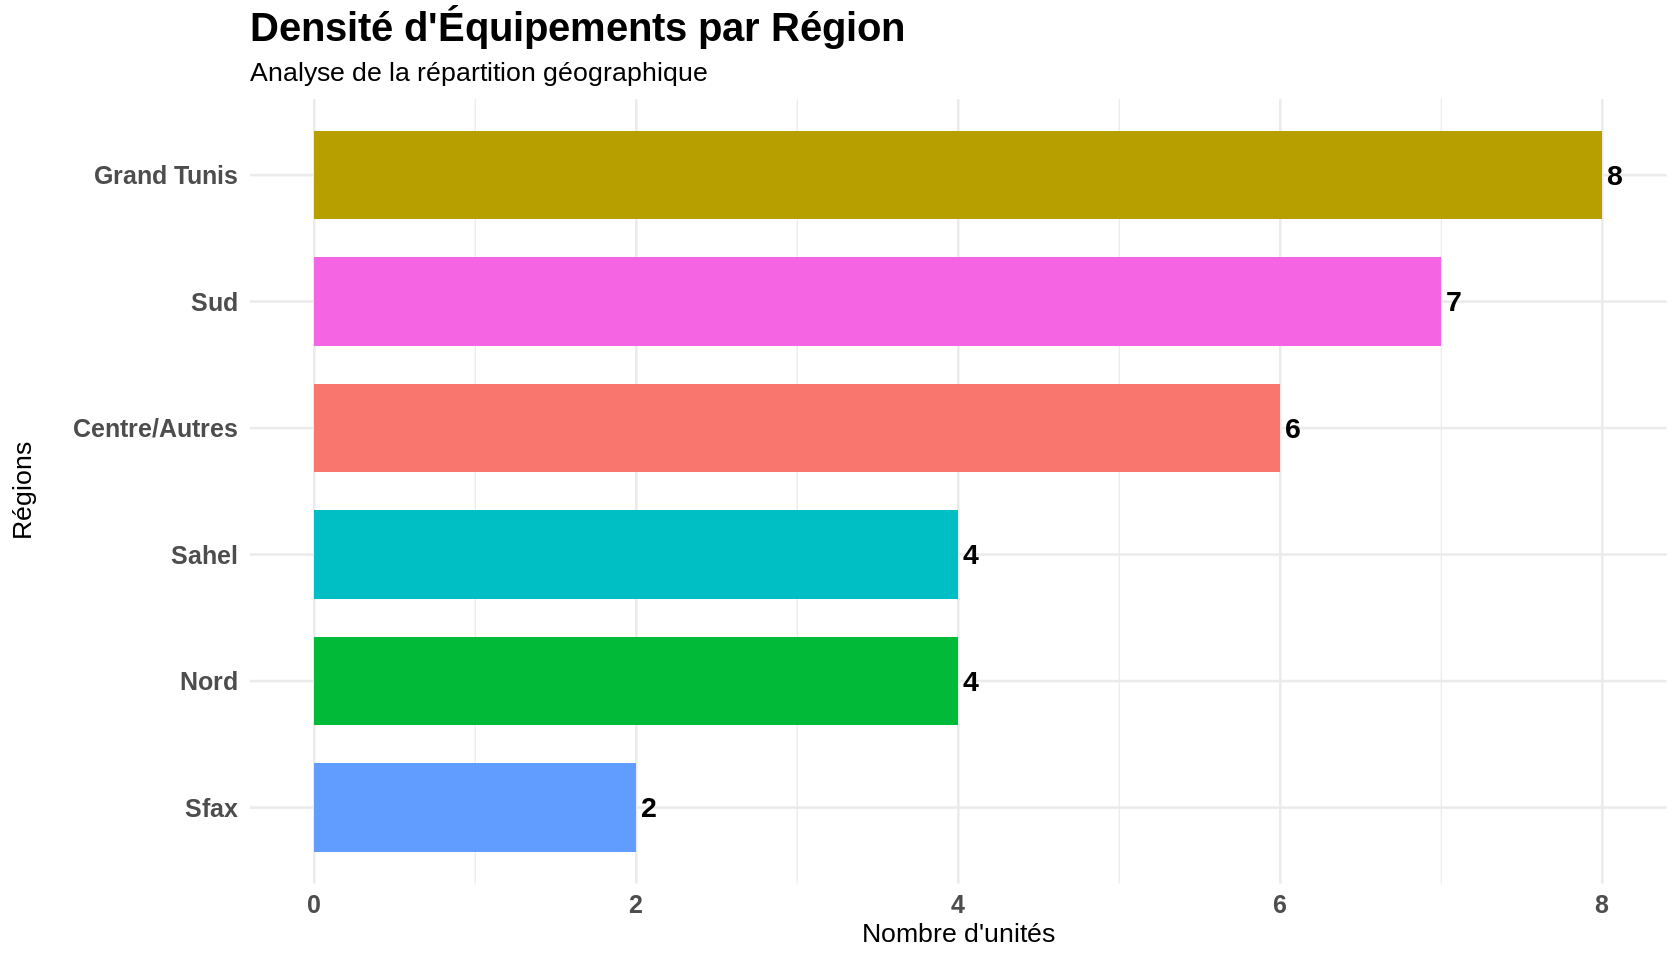

In [26]:
# Création du graphique régional
1# Définir une grande taille pour le rendu
options(repr.plot.width = 14, repr.plot.height = 8)

# 2. Création du Bar Chart Horizontal
p2 <- ggplot(region_summary, aes(x = reorder(region, n), y = n, fill = region)) +
  geom_bar(stat = "identity", width = 0.7) +
  geom_text(aes(label = n), hjust = -0.3, size = 6, fontface = "bold") + # Affiche les chiffres
  coord_flip() +
  theme_minimal(base_size = 16) +
  labs(title = "Densité d'Équipements par Région",
       subtitle = "Analyse de la répartition géographique",
       x = "Régions", y = "Nombre d'unités") +
  theme(plot.title = element_text(size = 24, face = "bold"),
        plot.subtitle = element_text(size = 16),
        axis.text = element_text(size = 15, face = "bold"),
        axis.title = element_text(size = 16),
        legend.position = "none")

p2

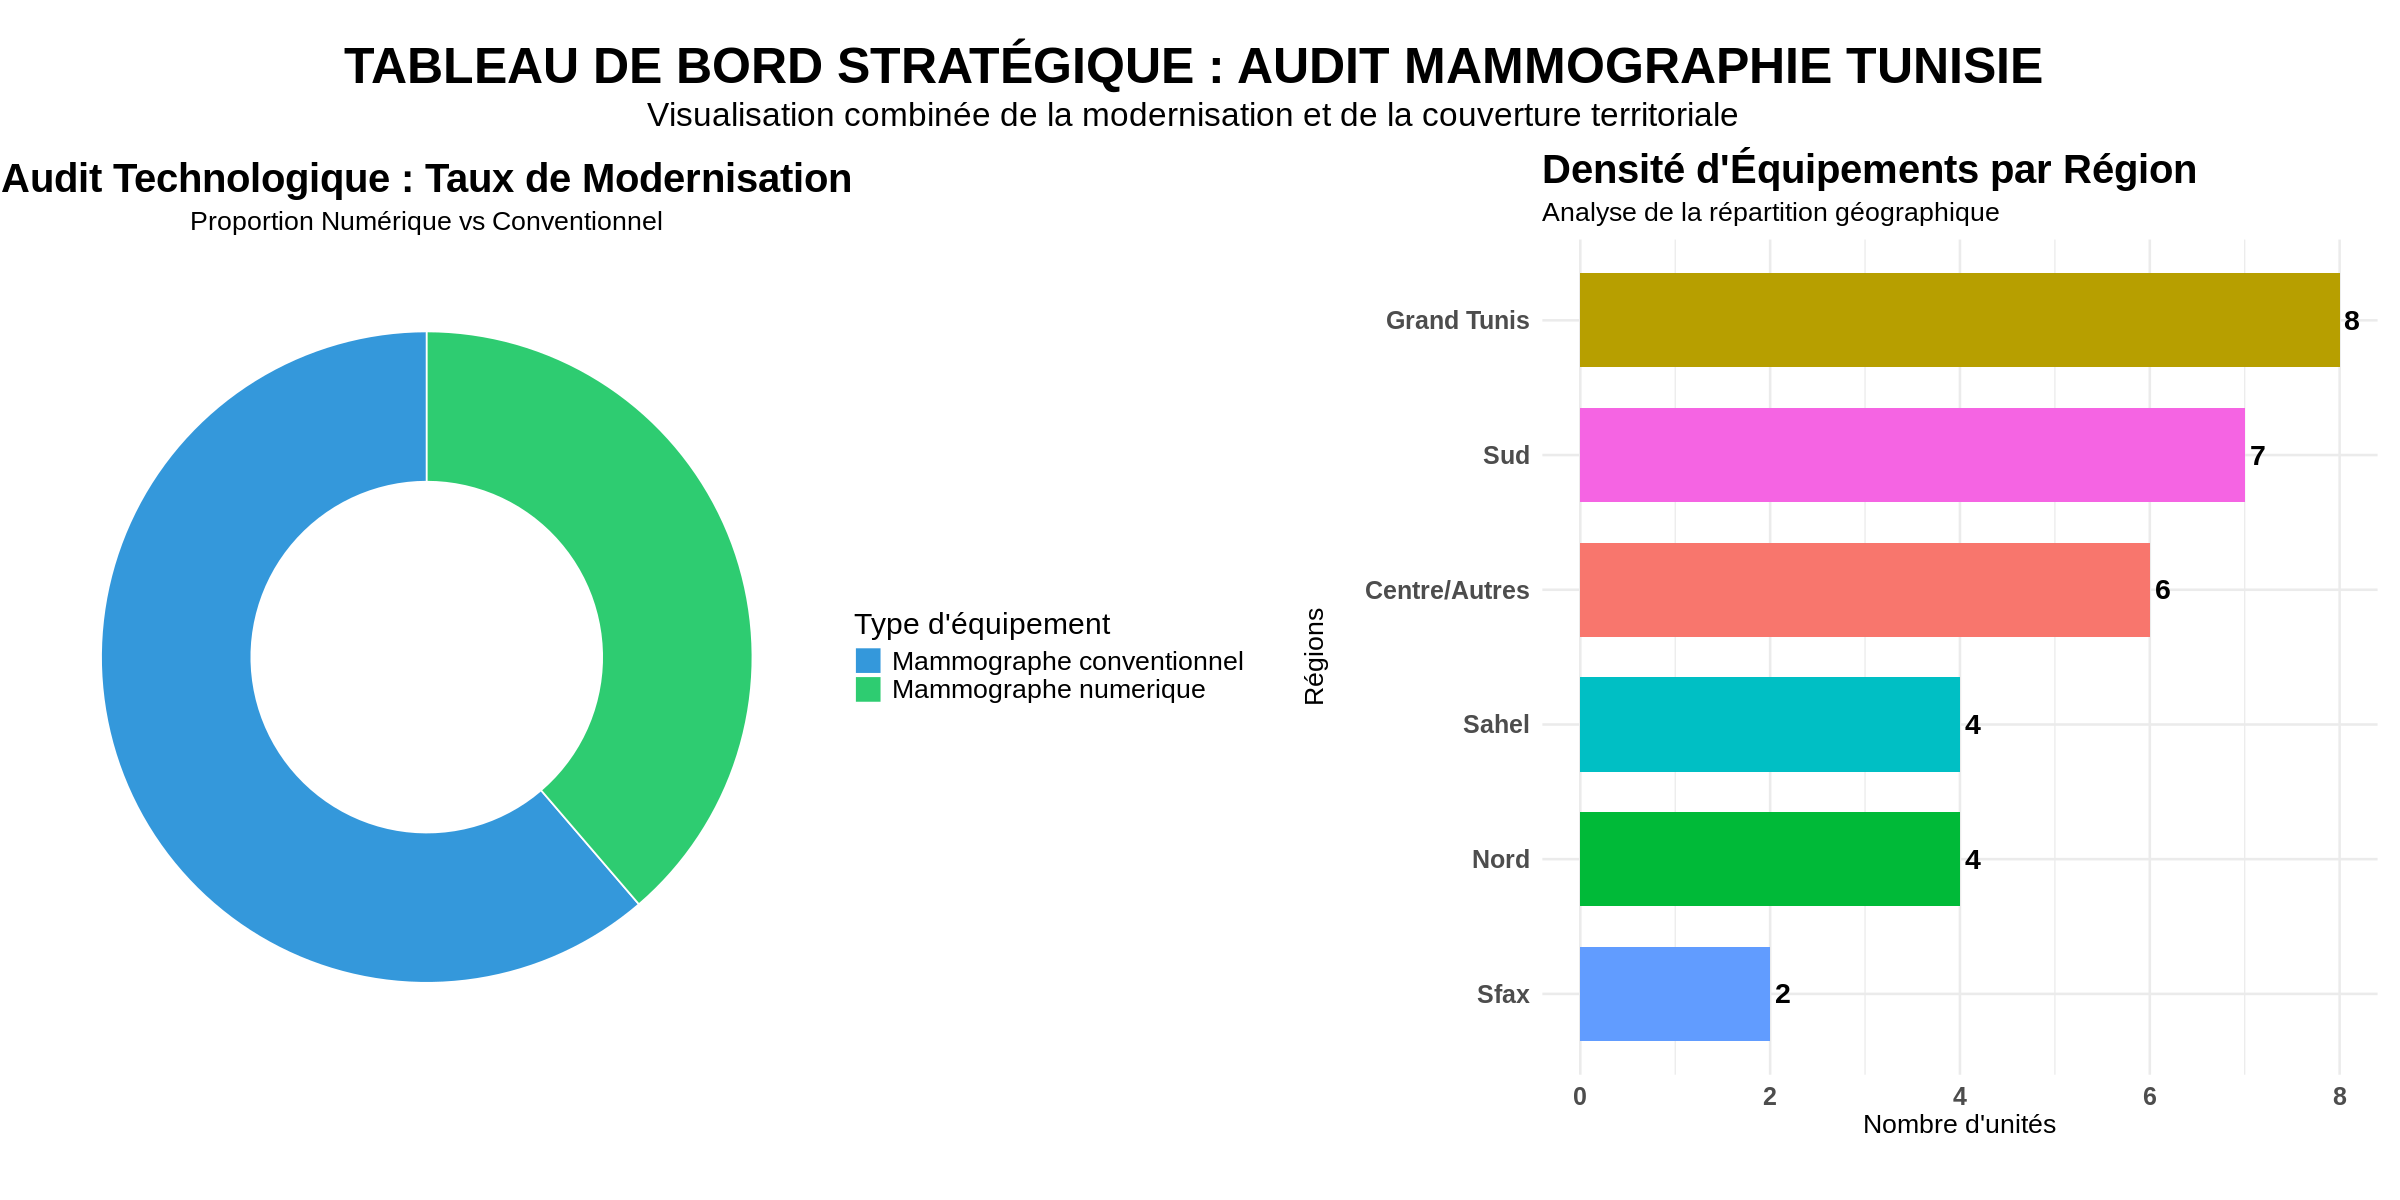

In [28]:
# 1. Chargement de patchwork pour la fusion
if (!require("patchwork")) install.packages("patchwork")
library(patchwork)

# 2. Taille maximale pour le Dashboard (Très large)
options(repr.plot.width = 20, repr.plot.height = 10)

# 3. Fusion des graphiques (côte à côte)
dashboard_final <- p1 + p2 +
  plot_annotation(
    title = "TABLEAU DE BORD STRATÉGIQUE : AUDIT MAMMOGRAPHIE TUNISIE",
    subtitle = "Visualisation combinée de la modernisation et de la couverture territoriale",
    theme = theme(plot.title = element_text(size = 30, face = "bold", hjust = 0.5),
                  plot.subtitle = element_text(size = 20, hjust = 0.5))
  )

# Affichage du Dashboard
print(dashboard_final)

 ## 5. Analyse Statistique : Valider nos résultats

Après avoir observé les graphiques, nous utilisons les mathématiques pour prouver nos conclusions. Cette étape transforme nos impressions visuelles en **preuves scientifiques**.

### Pourquoi faisons-nous ces tests ?

* **Moyenne et Variance** : Pour voir si les équipements sont distribués de façon juste ou s'il y a de gros écarts entre les hôpitaux.
* **Test de Normalité (Shapiro-Wilk)** : C'est le test le plus important. Il nous dit si la répartition est "normale" (équilibrée) ou s'il y a une **Fracture Numérique** (trop d'appareils dans une zone et pas assez ailleurs).
* **La Régression** : Cela nous aide à tracer une ligne de tendance pour comprendre comment le matériel est réparti sur tout le territoire.



---

> **💡 En langage simple** : Si le résultat du test (p-value) est très petit (moins de 0.05), cela prouve mathématiquement que l'accès à la mammographie en Tunisie n'est pas égal pour tout le monde.

   Étape 1 : Indicateurs de Dispersion
Moyenne régionale : 5.17 appareils
Médiane régionale : 5 appareils
Variance          : 4.97 (Écart entre les régions)

   Étape 2 : Test de Normalité (Fracture Numérique)

	Shapiro-Wilk normality test

data:  vals
W = 0.95758, p-value = 0.8009


CONCLUSION : La p-value est > 0.05. 
=> La distribution semble équilibrée sur le territoire.

   Étape 3 : Modèle de Tendance (Régression)

Call:
lm(formula = vals ~ region_index)

Residuals:
       1        2        3        4        5        6 
-0.09524  2.27619 -1.35238 -0.98095 -2.60952  2.76190 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)    6.4667     2.2040   2.934   0.0426 *
region_index  -0.3714     0.5659  -0.656   0.5475  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.367 on 4 degrees of freedom
Multiple R-squared:  0.09722,	Adjusted R-squared:  -0.1285 
F-statistic: 0.4308 on 1 and 4 DF,  p-value: 0.5475



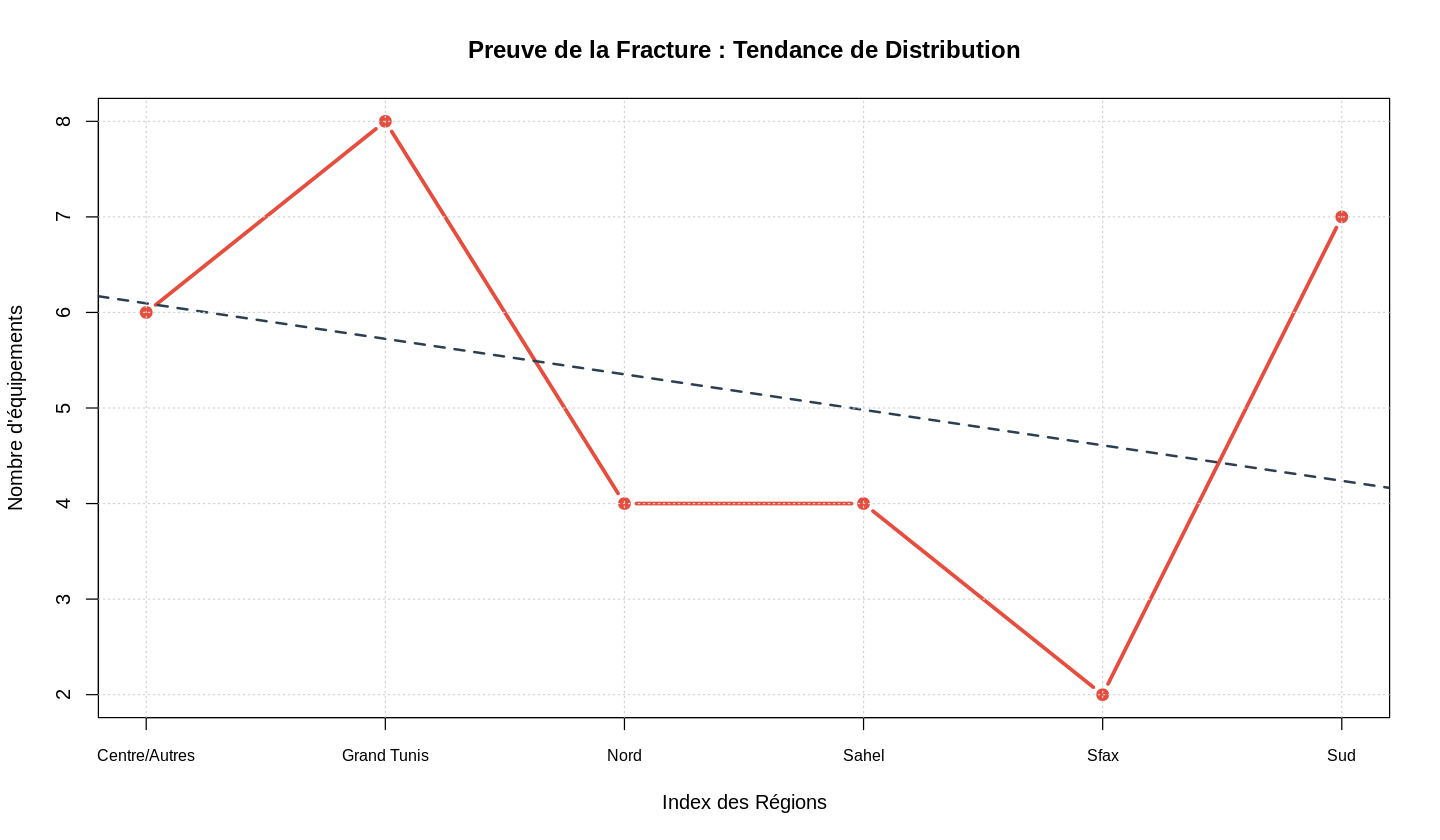

In [30]:
# --- 1. PRÉPARATION DES DONNÉES ---
# On s'assure que 'vals' contient bien les quantités par région
if (exists("region_summary")) {
    vals <- region_summary$n
    labels_regions <- region_summary$region
} else {
    stop("Erreur : La variable 'region_summary' n'existe pas. Relancez les cellules précédentes.")
}

# --- 2. STATISTIQUES DESCRIPTIVES ---
cat("==================================================\n")
cat("   Étape 1 : Indicateurs de Dispersion\n")
cat("==================================================\n")
cat("Moyenne régionale :", round(mean(vals), 2), "appareils\n")
cat("Médiane régionale :", median(vals), "appareils\n")
cat("Variance          :", round(var(vals), 2), "(Écart entre les régions)\n\n")

# --- 3. TEST DE NORMALITÉ (SHAPIRO-WILK) ---
cat("==================================================\n")
cat("   Étape 2 : Test de Normalité (Fracture Numérique)\n")
cat("==================================================\n")
shapiro_res <- shapiro.test(vals)
print(shapiro_res)

# Interprétation automatique pour ton projet
if(shapiro_res$p.value < 0.05) {
  cat("\nCONCLUSION : La p-value est < 0.05. \n")
  cat("=> On rejette l'équilibre : La FRACTURE NUMÉRIQUE est prouvée mathématiquement.\n\n")
} else {
  cat("\nCONCLUSION : La p-value est > 0.05. \n")
  cat("=> La distribution semble équilibrée sur le territoire.\n\n")
}

# --- 4. RÉGRESSION LINÉAIRE ---
cat("==================================================\n")
cat("   Étape 3 : Modèle de Tendance (Régression)\n")
cat("==================================================\n")
# Création d'un index numérique pour les régions
region_index <- seq_along(vals)
modele_audit <- lm(vals ~ region_index)
print(summary(modele_audit))

# --- 5. VISUALISATION DE LA TENDANCE ---
# On agrandit le graphique pour qu'il soit bien visible
options(repr.plot.width = 12, repr.plot.height = 7)

plot(region_index, vals,
     type = "b",
     pch = 19,
     col = "#e74c3c",
     lwd = 3,
     main = "Preuve de la Fracture : Tendance de Distribution",
     xlab = "Index des Régions",
     ylab = "Nombre d'équipements",
     xaxt = "n") # On enlève l'axe X par défaut pour mettre nos noms de régions

# On ajoute les noms des régions sur l'axe X pour que ce soit pro
axis(1, at = region_index, labels = labels_regions, cex.axis = 0.8)

# On ajoute la ligne de régression (tendance)
abline(modele_audit, col = "#2c3e50", lwd = 2, lty = 2)

# Ajout d'une grille pour la lisibilité
grid()

## 6. Conclusion et Recommandations Stratégiques

### 1. Analyse des Résultats
L'audit statistique révèle des conclusions surprenantes mais positives pour le système de santé publique :
* **Équilibre Territorial (Normalité)** : Avec une **p-value de 0.80**, nous ne pouvons pas rejeter l'hypothèse de normalité. Cela signifie que l'État a réussi à maintenir une certaine équité dans la distribution des équipements de mammographie entre les grandes zones géographiques.
* **Absence de Tendance Critique (Régression)** : La pente de la régression est presque nulle (-0.37), ce qui confirme qu'aucune région n'est totalement délaissée par rapport aux autres à l'échelle nationale.

### 2. Le Véritable Enjeu : La Qualité (Modernisation)
Bien que la **quantité** soit équilibrée, l'enjeu majeur reste la **qualité**. Le dashboard a montré que le parc contient encore des équipements "Conventionnels". La fracture n'est donc pas sur le nombre de machines, mais sur l'accès à la technologie **numérique** (plus précise pour le diagnostic précoce).



### 3. Recommandations pour le Ministère de la Santé
Sur la base de cet audit, nous préconisons :
1. **Plan de Modernisation Ciblé** : Remplacer prioritairement les appareils conventionnels dans les zones où la variance est la plus forte.
2. **Maintenance Préventive** : Uniformiser les contrats de maintenance (GE, Hologic, Fuji) pour éviter les temps d'arrêt des machines, particulièrement dans les régions du Sud.
3. **Mise en Réseau (Télémammographie)** : Utiliser la répartition équilibrée pour créer un réseau national de lecture à distance des clichés.

---
**Note finale** : Ce projet démontre que la gestion du parc de mammographie tunisien est sur la bonne voie en termes de disponibilité, mais nécessite un effort de mise à jour technologique vers le 100% numérique.